# Tracking Code

Track a spherical colloid from Mie-holography videos. Results are saved in SI, in a .mat file. 

Usage: Start from .p4 videos. Copy-past the track.ipynb code to the folder containing the video. Not necessary but helps keeping track of what is done during the tracking.

To install the required packages: see associated note.

# Importations

In [1]:
import sys

In [2]:
import os
os.environ.setdefault("OMP_NUM_THREADS","1") # export OMP_NUM_THREADS=1
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1") # export OPENBLAS_NUM_THREADS=1
os.environ.setdefault("MKL_NUM_THREADS","1") # export MKL_NUM_THREADS=1
os.environ.setdefault("VECLIB_MAXIMUM_THREADS","1") # export VECLIB_MAXIMUM_THREADS=1
os.environ.setdefault("NUMEXPR_NUM_THREADS","1") # export NUMEXPR_NUM_THREADS=1

'1'

In [3]:
import subprocess
import glob

In [4]:
import wraplorenzmie

In [5]:
from wraplorenzmie.pylorenzmie.utilities import azimedian, azistd

In [6]:
%matplotlib widget
import ipywidgets as widgets

In [7]:
import wraplorenzmie.utilities.utilities as utilities

import wraplorenzmie.fits.fit as fit
#import imageio
# For Plotting.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#sns.set(style='white', font_scale=2)
%matplotlib inline
import matplotlib as mpl

mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["lines.markeredgecolor"] = "k"
mpl.rcParams["lines.markeredgewidth"] = 0.1
mpl.rcParams["figure.dpi"] = 130
from matplotlib import rc
rc('font', family='serif')
rc('text', usetex=False)
rc('xtick', labelsize='medium')
rc('ytick', labelsize='medium')

def cm2inch(value):
    return value/2.54

INFO:configuration: CATCH deselected in /home/brownianxgames/miniconda3/envs/pylorenzmie-2/lib/python3.10/site-packages/pylorenzmie/utilities/configuration.py
INFO:configuration: Falling back to standard implementation


Using Cupy


In [8]:
from scipy.io import savemat

# Inputs

In [11]:
# Calibration (um/px)
calib = 0.05840
# Wavelength of the illumination (must be in um)
wavelength = 0.532
# Acquisition framerate
fps = 50
# Liquid's medium
n_m = 1.33

In [13]:
# Filename for the video
filename = glob.glob("*.mp4")[0]

In [14]:
foldername = os.path.basename(os.getcwd())
foldername

'confined_next_day'

In [ ]:
# If you want to trim the video, uncomment the next couple of cells.

In [15]:
# filename_trimmed = filename[:-4] + "_trimmed_start_at_5min.mp4"

# from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
# ffmpeg_extract_subclip(filename, 5*60, 1000*60, targetname=filename_trimmed[:])

In [16]:
# filename = filename_trimmed

In [17]:
filename

'Basler_acA1920-155um__22392621__20250121_110245592.mp4'

In [18]:
# Create the python's object (class) corresponding to the video
vid = utilities.video_reader(filename)

In [19]:
# Get the number of images in the video
try:
    cmd = r"ffprobe -v error -select_streams v:0 -count_packets -show_entries stream=nb_read_packets -of csv=p=0 " + filename
    nb_image = int(subprocess.check_output(cmd, shell=True))
except:
    print('Something went wrong. Please enter the number of images manually.')
    nb_image = int(input())
print(nb_image)

100611

In [23]:
# Update vid
vid.number = nb_image

# Work On One Image

In [24]:
# Change if you want to start at something else than first frame
n_start = 0

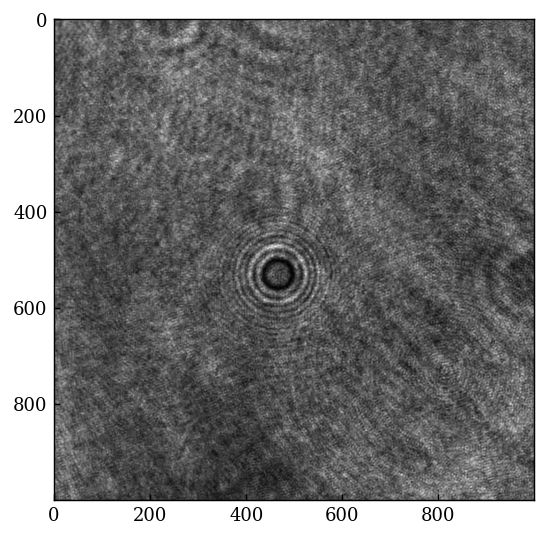

In [25]:
# Get first image and plot
image = vid.get_image(n_start)
plt.imshow(image,cmap="gray")

(21, 1000, 1000)


100%|███████████████████████████████████████████| 21/21 [00:06<00:00,  3.37it/s]


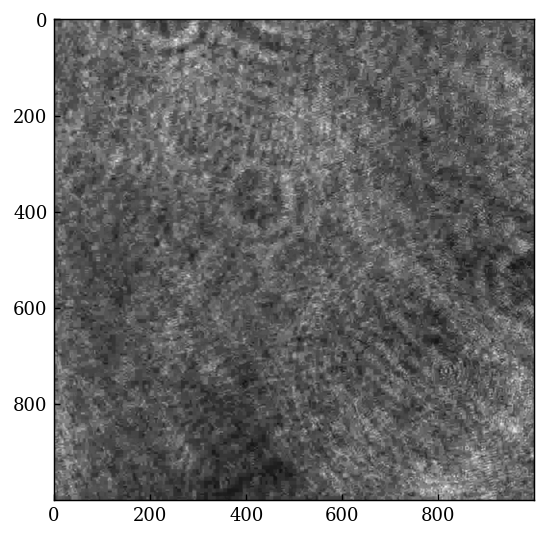

In [26]:
# Compute the background of the video
# The current method won't work for gliding: TO BE DISCUSSED
buf, background = vid.get_background(20)
#background = np.ones_like(image)* np.mean(image)
vid.background = background
plt.imshow(vid.background,cmap="gray")

In [27]:
#imageio.imwrite("background"+generic_output_name+".tiff", vid.background)

In [28]:
# No zeros in the bg
vid.background[vid.background == 0] = 1  

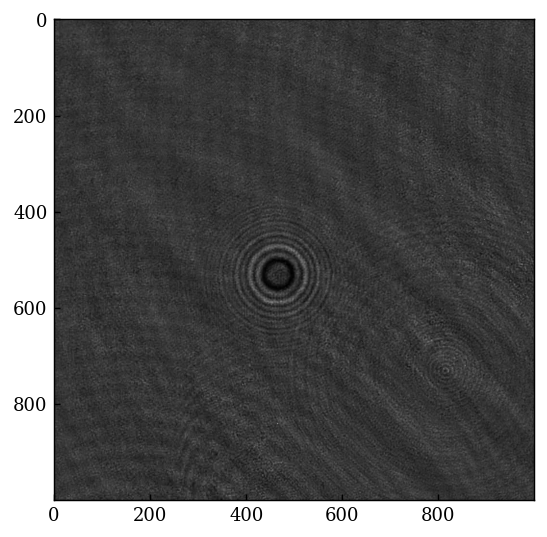

In [29]:
# Normalize first image and plot
normed_image = utilities.normalize(image, vid.background)
plt.imshow(normed_image, cmap="gray")
# normed_image = normed_image

In [34]:
# Find the center of the hologram 
feature = utilities.center_find(normed_image)
feature

[{'x_p': 470.8688258304051,
  'y_p': 523.247530332162,
  'bbox': ((178, 231), 584, 584)}]

In [35]:
# Uncomment next box if nothing was found and enter approximate position manually

In [36]:
# feature = [{}]

# feature[0]["x_p"] = 470
# feature[0]["y_p"] = 410
# feature[0]["bbox"] = [200, 200, 200]

In [37]:
x, a, b = feature[0]["bbox"]

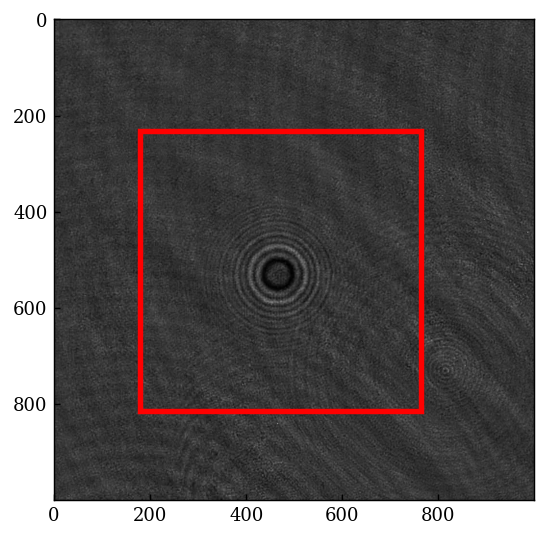

In [38]:
utilities.plot_bounding(normed_image,feature)

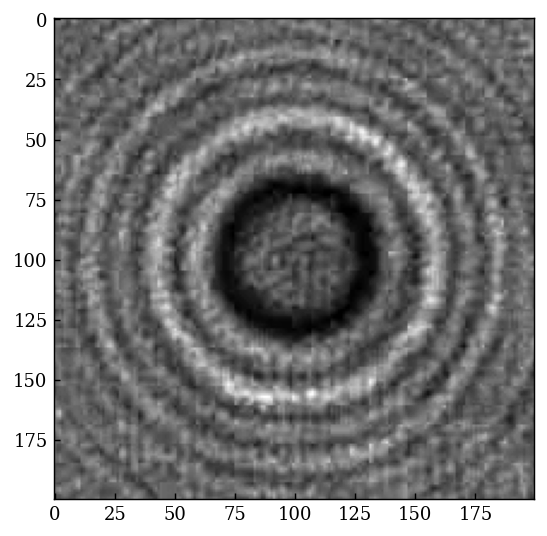

In [47]:
# More precision on the center determination
i = 0 # index of the hologram wanted
x, y, w, h = [feature[i]['x_p'], feature[i]['y_p'],*feature[i]["bbox"][1:]]
x = x - 5
y = y + 8
x_center = x
y_center = y
h = 200 # box size
im_c = fit.crop(image, int(x), int(y), int(h))
bk_c = fit.crop(vid.background, int(x), int(y), int(h))
cropped = utilities.normalize(im_c,bk_c, dark_count = np.min(im_c))
# cropped = im_c
plt.imshow(cropped,cmap = "gray")

In [48]:
# Define the fitting class
fitter = fit.fitting(cropped, wavelength, calib, n_m = n_m, percentpix=1, mask="fast", double_precision=True)
# fitter.show_mask()

In [52]:
# First guess
# Order = radius, index, z
fitter.make_guess(1.47, 1.59, 10, show_estimate=True)

npixels = 39998
x_p = 99.6446 +- 0.0156
y_p = 99.6420 +- 0.0151
z_p = 170.2906 +- 0.0779
a_p = 1.4740 +- 0.0011
n_p = 1.5808 +- 0.0003
chisq = 1.93


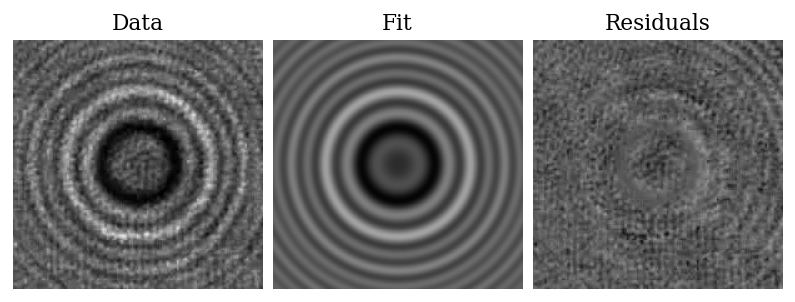

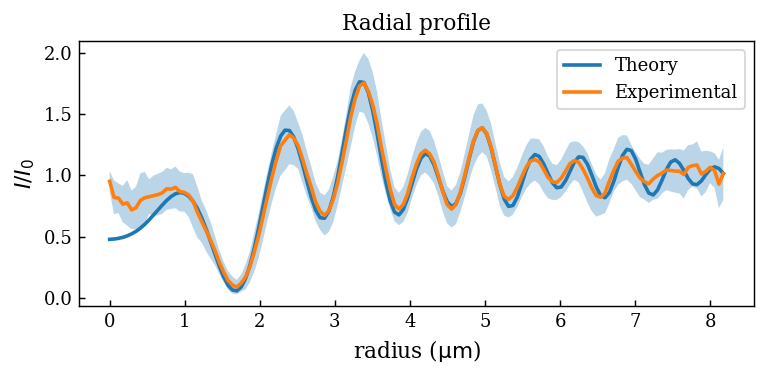

Distance to the objective (in um) = 
9.94496926273408


In [53]:
# Fit the first image 
# vary = ['x_p', 'y_p', 'z_p', 'a_p']
vary = ['x_p', 'y_p', 'z_p', "a_p", "n_p"]
fitter.set_vary(vary)
result = fitter.optimize(report = True, present=True, radial_profile = True)
print('Distance to the objective (in um) = ')
print(result['z_p'] * calib)

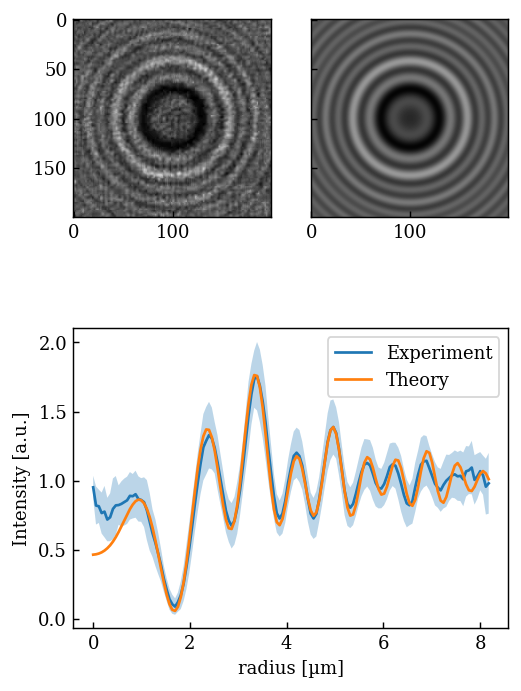

In [54]:
# Summary plot and save

fit_data = {}

fig = plt.figure(figsize=(cm2inch(10),cm2inch(15)))
fig.subplots_adjust(left=0.14, bottom=.12, right=.99, top=.98)

plt.subplot(2,2,1)
plt.imshow(fitter.feature.data, cmap = "gray", vmin=0, vmax=3)

fit_data["exp_image"] = fitter.feature.data

plt.subplot(2,2,2)
plt.imshow(fitter.feature.hologram().reshape(fitter.shape), cmap = "gray", vmin=0, vmax=3)
frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([])

fit_data["th_image"] = fitter.feature.hologram().reshape(fitter.shape)

from pylorenzmie.utilities import azistd
center = (fitter.feature.optimize()['x_p'], fitter.feature.optimize()['y_p'])
expe_avg, expe_std = azistd(fitter.feature.data, center)
r_exp = np.arange(len(expe_avg)) * fitter.ins.magnification
th_avg, th_std = azistd(fitter.feature.hologram(), center)
r_th = np.arange(len(th_avg)) * fitter.ins.magnification

plt.subplot(2,2,(3,4))
plt.plot(r_exp, expe_avg, label="Experiment")
plt.fill_between(r_exp, expe_avg - expe_std, expe_avg + expe_std, alpha = 0.3)
plt.plot(r_th, th_avg, label="Theory")
plt.legend()
plt.xlabel("radius [µm]")
plt.ylabel("Intensity [a.u.]")

fit_data["expe_avg"] = expe_avg
fit_data["expe_std"] = expe_std
fit_data['r_exp'] = r_exp

fit_data["th_avg"] = th_avg
fit_data["th_std"] = th_std
fit_data['r_th'] = r_th

plt.tight_layout()
plt.savefig("first_im_fig_vid_{0}.pdf".format(foldername))
plt.show()

savemat('first_im_data_vid_{0}.mat'.format(foldername), fit_data)

In [55]:
# Fit images to determine r-n
fitter.fit_video(
    vid = vid, savefile="find_nr.dat", 
    xc = x_center ,yc = y_center, h=h, 
    n_start=n_start, n_end=n_start+5000, 
    method = "lm", dark_count_mode="min", loss="linear", percentpix = 0.5, 
    update_mask=True, moving_background=False, 
)

100%|███████████████████████████████████████| 5000/5000 [04:55<00:00, 16.93it/s]


In [56]:
# Get data RN from the fits
n_r = np.fromfile("find_nr.dat", dtype=np.float64)
n_r = n_r.reshape(len(n_r)//13,13)
n_r = n_r[:,:]
# n_r is an array. 
# Lines = different images 
# Columns = x, y, z, rp, np
r = n_r[:,3]
n = n_r[:,4]
# n_r = n_r.reshape(len(n_r)//4,4)
# n = n_r[:,3]

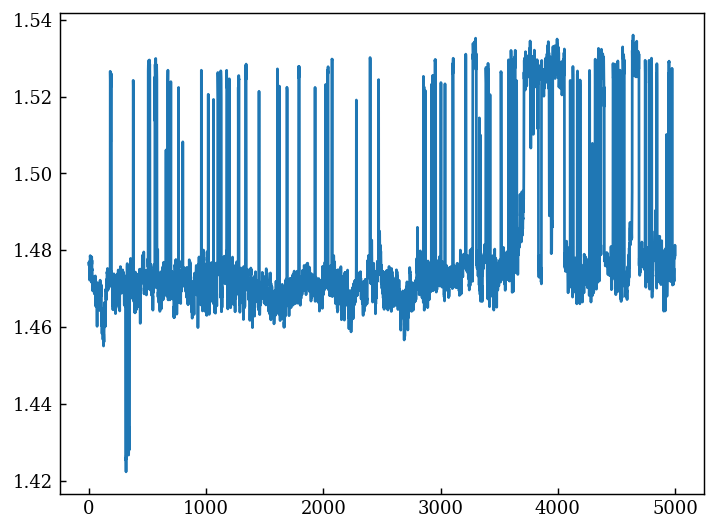

In [57]:
plt.plot(r)

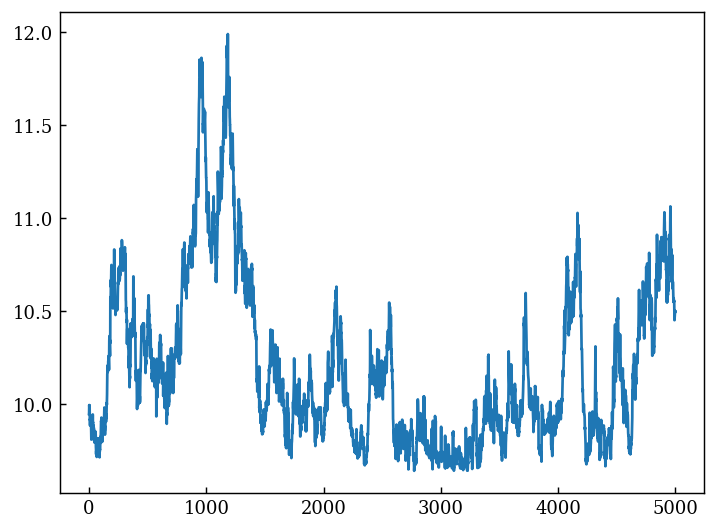

In [58]:
plt.plot(n_r[:,2]*calib)

/home/brownianxgames/miniconda3/envs/pylorenzmie-2/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

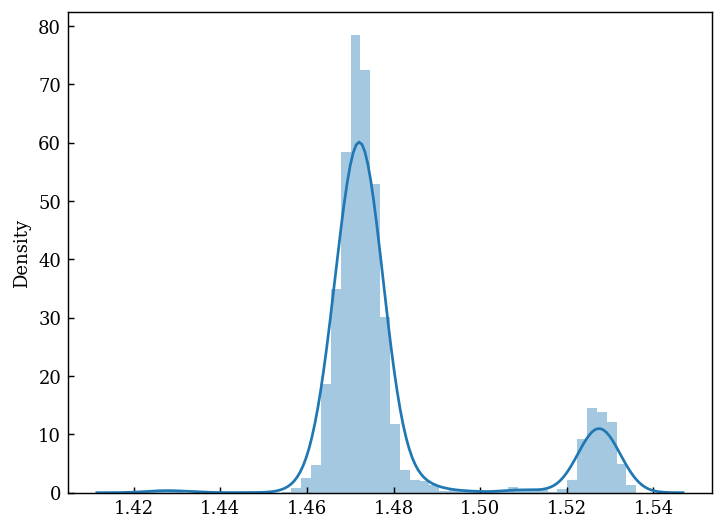

In [59]:
sns.distplot(r)
# 

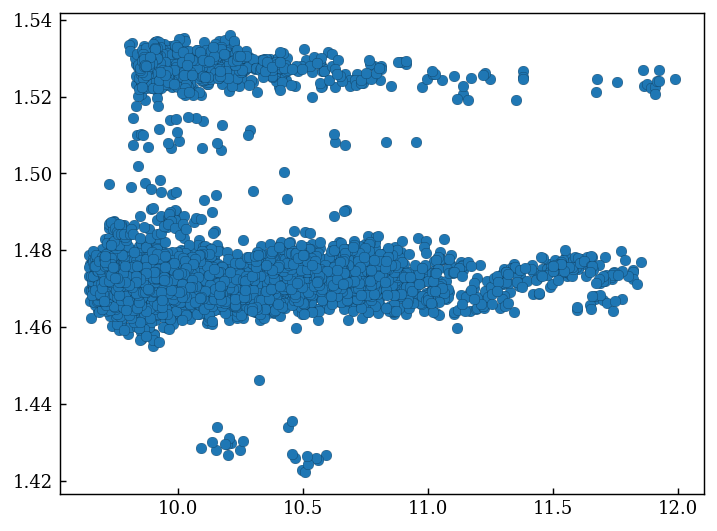

In [60]:
plt.plot(n_r[:,2]*calib, n_r[:,3], 'o')

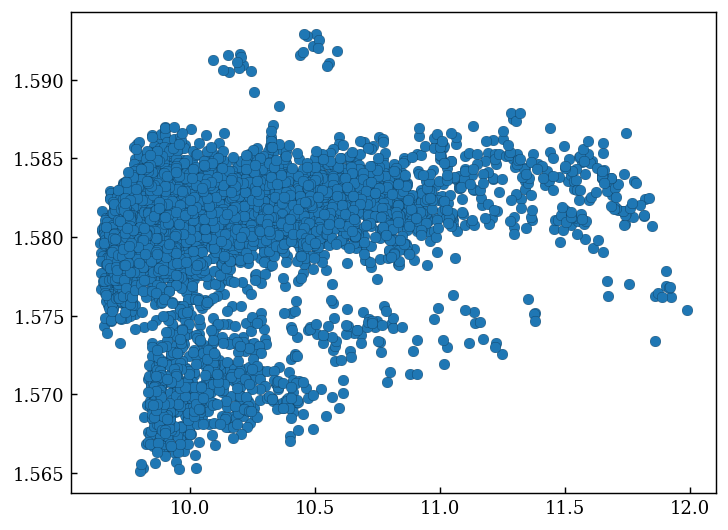

In [61]:
plt.plot(n_r[:,2]*calib, n_r[:,4], 'o')

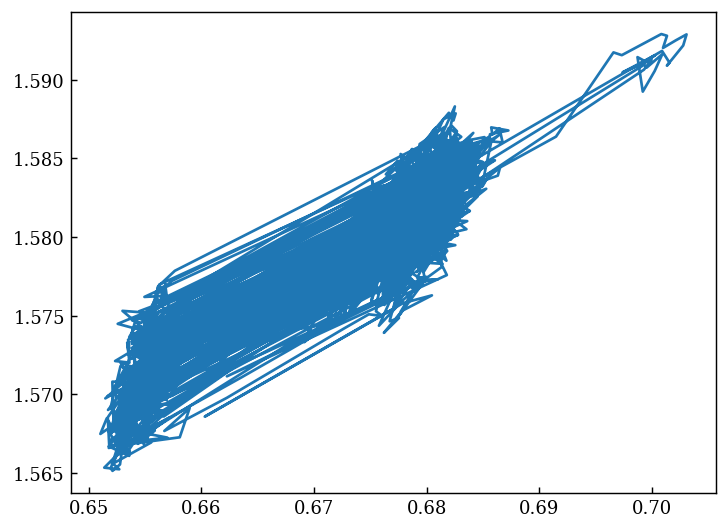

In [62]:
plt.plot(n_r[:, 3]**-1, n_r[:,4])

Text(0.5, 0, 'r [$\\mathrm{\\mu m}$]')

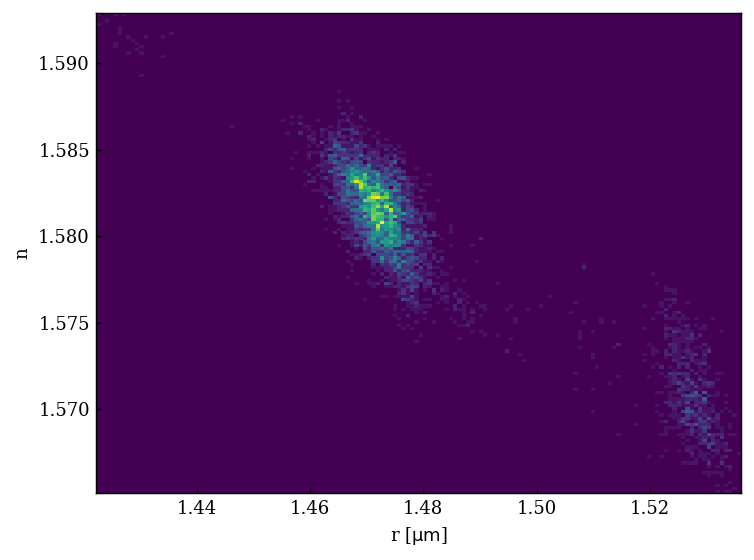

In [63]:
H, xedges, yedges = np.histogram2d(n, r, bins=100)
H = H.T  # Let each row list bins with common y range.


plt.hist2d(r,n, bins = 150)
plt.ylabel("n")
plt.xlabel("r [$\mathrm{\mu m}$]")



Text(0.5, 1.0, 'KDE r n')

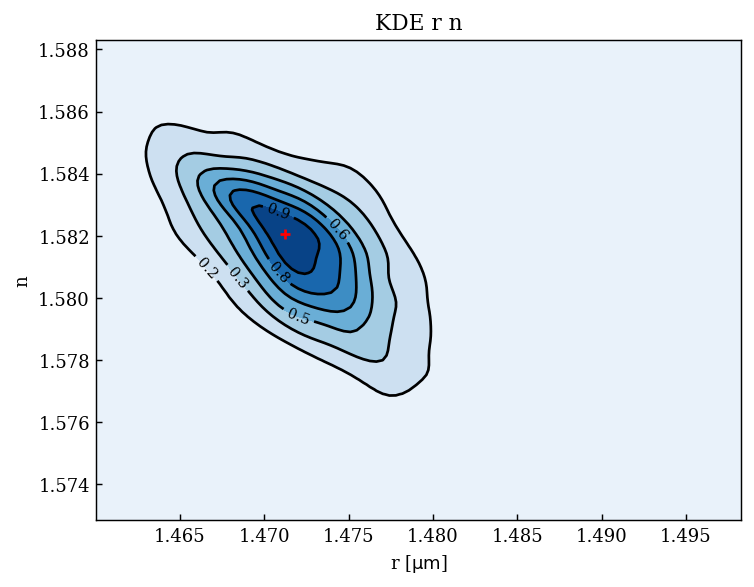

In [64]:
# Plot the 2D kernel histogram

# Choose the range of r to plot
rmin = 1.46
rmax = 1.50

import numpy as np
import matplotlib.pyplot as pl
import scipy.stats as st

data = np.random.multivariate_normal((0, 0), [[0.8, 0.05], [0.05, 0.7]], 100)
x = r[(r>rmin) & (r<rmax)]
y = n[(r>rmin) & (r<rmax)]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)
f = f/np.max(f)

fig = plt.figure()
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, colors='k', levels=6)
# Label plot
ax.clabel(cset, inline=1, fontsize=8, fmt="%1.1f")
plt.scatter(xx[np.where(f == 1)],yy[np.where(f == 1)], color = "red", marker="+")
ax.set_xlabel("r [$\mathrm{\mu m}$]")
ax.set_ylabel("n")
plt.title("KDE r n")

#pl.show()



In [65]:
print(" n determined with : mu={0}, sigma={1}".format(np.mean(yy[np.where(f == 1)]), np.std(yy[np.where(f > 0.2)])))
print(" r determined with : mu={0}, sigma={1}".format(np.mean(xx[np.where(f == 1)]), np.std(xx[np.where(f > 0.2)])))


mu_n, sigma_n = np.mean(yy[np.where(f == 1)]), np.std(yy[np.where(f > 0.2)])
mu_r, sigma_r = np.mean(xx[np.where(f == 1)]), np.std(xx[np.where(f > 0.2)])

# print(" n determined with : mu={0}, sigma={1}".format(np.mean(n), np.std(n)))
# mu_n, sigma_n = np.mean(n), np.std(n)

 n determined with : mu=1.5820510996912127, sigma=0.0019204373230120146
 r determined with : mu=1.4712453014608577, sigma=0.003901277553378938


In [66]:
# If you want to input manually from another video

# mu_n = 1.6052716295305858
# mu_r = 1.5409155931069645
# print(mu_n)
# print(mu_r)

In [67]:
txt_rp = str(np.round(mu_r, 4))
txt_rp = txt_rp.replace('.', 'p')

txt_np = str(np.round(mu_n, 4))
txt_np = txt_np.replace('.', 'p')

In [68]:
vidsavename = 'traj_rp_{0}_np_{1}_vid_{2}'.format(txt_rp, txt_np, foldername)

In [69]:
vidsavename

'traj_rp_1p4712_np_1p5821_vid_confined_next_day'

In [70]:
h

200

In [71]:
# Fit the whole x, y, z of t
import warnings
warnings.filterwarnings('ignore')
vary = ['x_p', 'y_p', 'z_p']
#del fitter
h = h
im_c = fit.crop(image, int(x_center), int(y_center), int(h))
bk_c = fit.crop(vid.background, int(x_center), int(y_center), int(h))
cropped = utilities.normalize(im_c,bk_c, dark_count = np.min(im_c))
cropped = cropped / np.mean(cropped)
fitter = fit.fitting(cropped,wavelength,calib, n_m = n_m, percentpix=0.1, mask="fast", double_precision = False)
fitter.make_guess(mu_r,mu_n,result["z_p"]*calib, show_estimate = False)
fitter.set_vary(vary)
fitter.fit_video(
    vid = vid,
    savefile=vidsavename+'.dat',
    xc = x_center ,yc= y_center, h=h, 
    n_start=n_start, n_end=nb_image, 
    method = "lm", loss ="linear", dark_count_mode="min", percentpix = 0.3, 
    moving_background=False, 
)



100%|███████████████████████████████████| 100611/100611 [44:03<00:00, 38.06it/s]


In [72]:
import numpy as np
import matplotlib.pyplot as plt

In [73]:
filename = glob.glob("traj*.dat")[0]
traj = np.fromfile(filename, dtype=np.float64)
traj = traj.reshape(len(traj)//9,9)
traj[:,:6] = traj[:,:6]
data = {
    "x": traj[:,0] * 1e-6 * calib, 
    "y": traj[:,1] * 1e-6 * calib, 
    "z": traj[:,2] * 1e-6 * calib, 
    "dx": traj[:,3] * 1e-6 * calib, 
    "dy": traj[:,4] * 1e-6 * calib, 
    "dz": traj[:,5] * 1e-6 * calib, 
    'redchi': traj[:,8], 
    'filename': glob.glob("*.mp4")[0], 
}

savemat(filename[:-4] +'.mat', data)

In [74]:
traj = traj * calib * 1e-6

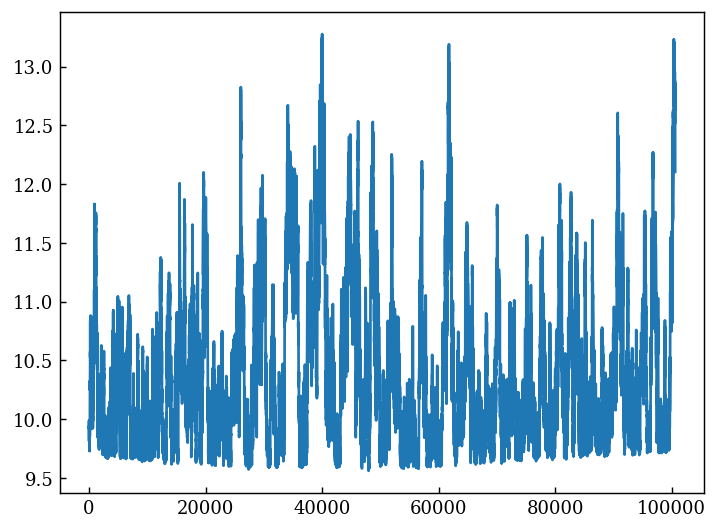

In [75]:
plt.figure()
plt.plot(traj[:,2] * 1e6)
plt.xlabel('Frame')
plt.ylabel(r'$z \, \mathrm{(\mu m)}$')
plt.show()

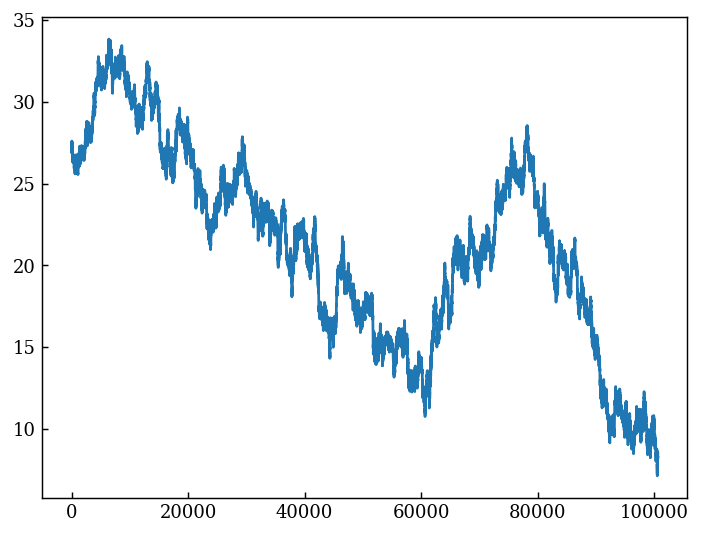

In [76]:
plt.figure()
# plt.add_subplot(121)
plt.plot(traj[:,0] * 1e6)
# plt.add_subplot(122)

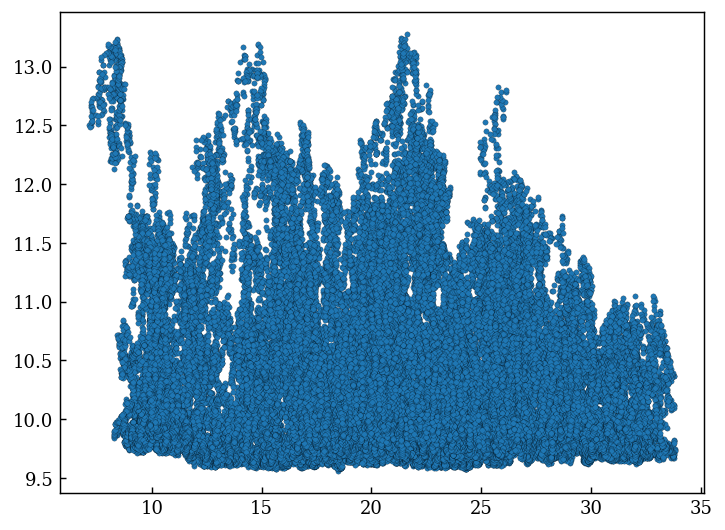

In [77]:
start = 0
stop = -1
plt.plot(traj[start:stop,0] * 1e6, traj[start:stop,2] * 1e6,".")
# plt.xlabel('y')
# plt.ylabel('z')

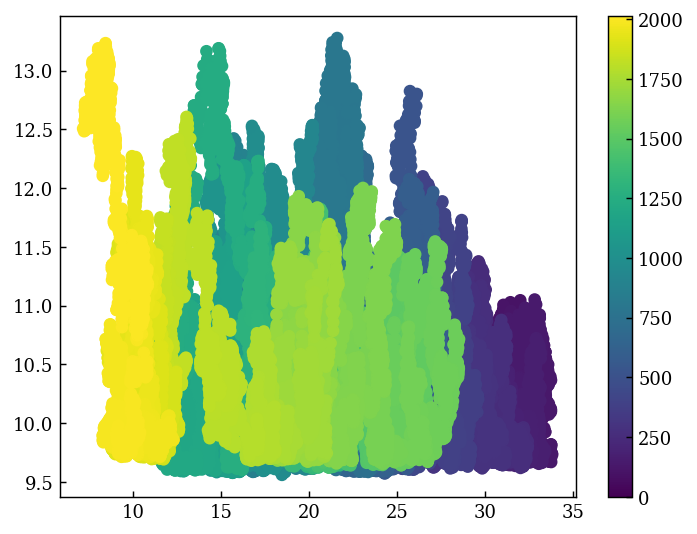

In [78]:
plt.scatter(traj[:,0] * 1e6, traj[:,2]* 1e6,cmap='viridis',c=np.arange(len(traj[:,0]))/fps)#np.arange(len(r)) / fps)
plt.colorbar()

In [79]:
# Select a part of the trajectory
traj = traj[:,:]

In [80]:
x, y, z = traj[:,0], traj[:,1], traj[:,2]
dx, dy, dz = traj[:,3], traj[:,4], traj[:,5]
redchi = traj[:,8]

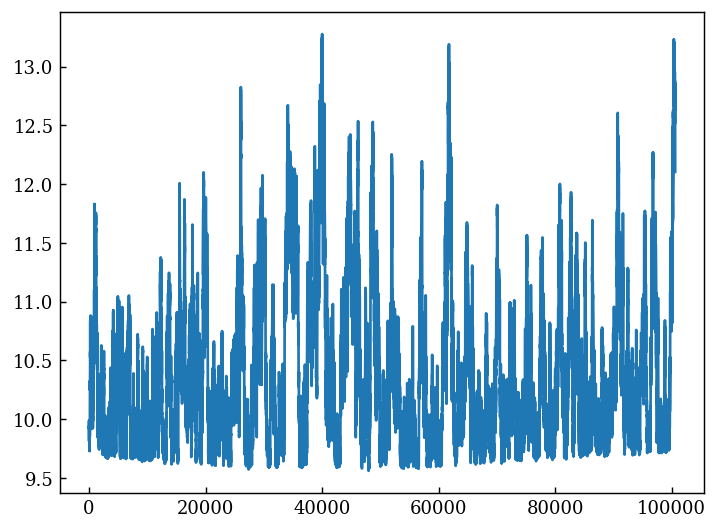

In [81]:
plt.figure()
plt.plot(traj[:,2] * 1e6)

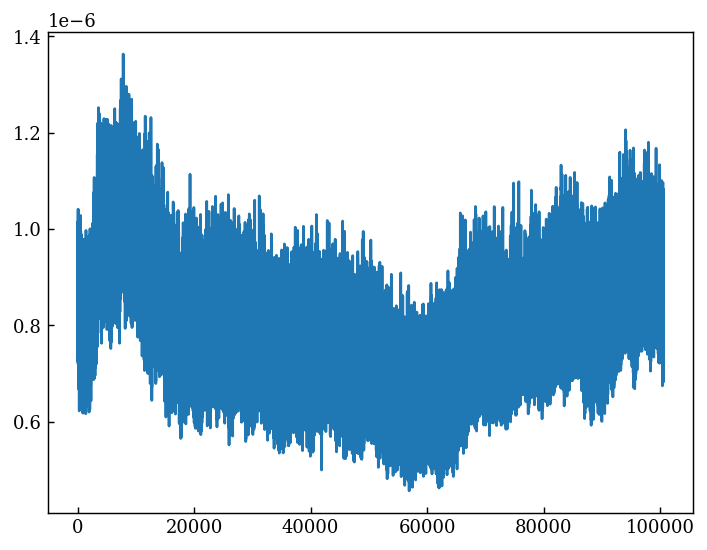

In [82]:
plt.figure()
plt.plot(redchi)

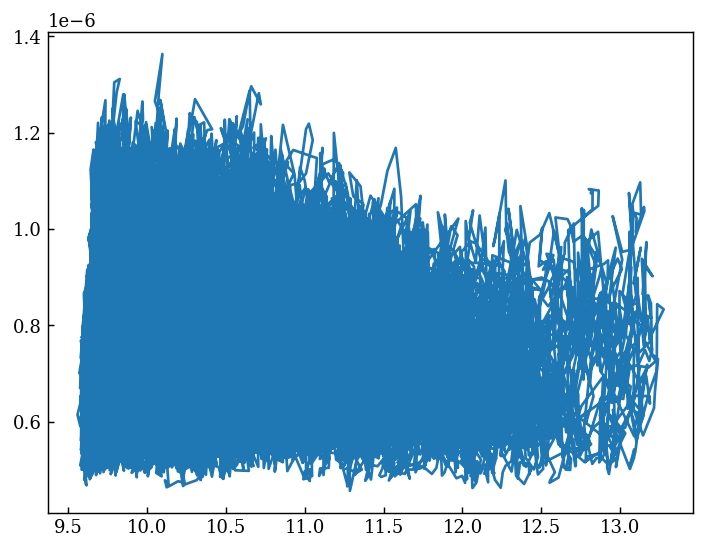

In [83]:
plt.figure()
plt.plot(z*1e6, redchi)

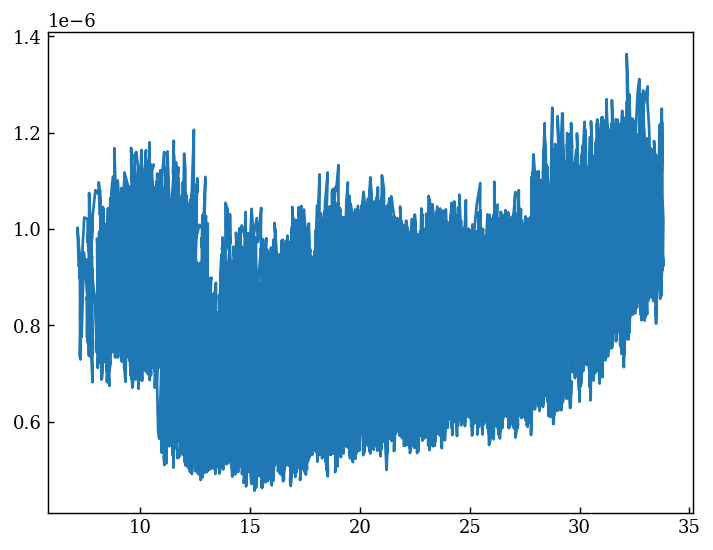

In [84]:
plt.figure()
plt.plot(x*1e6, redchi)
# plt.plot(y*1e6, redchi)

In [86]:
# MSDs

df = np.concatenate(
    (np.linspace(1, 10, 10), np.linspace(10, 100, 100), 
    np.linspace(100, 100000, 100), 
    )
)

dt = df / fps

In [87]:
msdx = np.zeros(len(df))
msdz = np.zeros(len(df))

for i, f in enumerate(df):
    f = int(f)
    msdx[i] = np.nanmean((traj[f:,0] - traj[:-f,0])**2)
    msdz[i] = np.nanmean((traj[f:,2] - traj[:-f,2])**2)

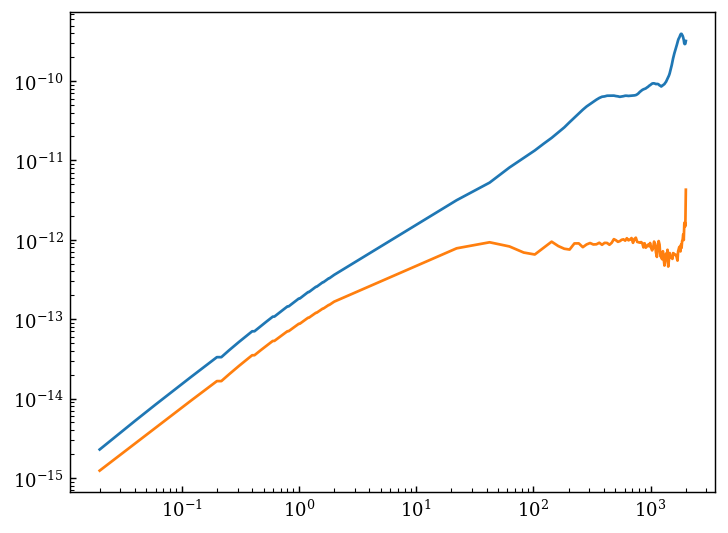

In [88]:
plt.loglog(dt, msdx)
plt.plot(dt, msdz)

In [89]:
def movmin(datas, k):
    result = np.empty_like(datas)
    start_pt = 0
    end_pt = int(np.ceil(k/2))
    for i in range(len(datas)):
        if i < int(np.ceil(k/2)):
            start_pt = 0
        if i > len(datas) - int(np.ceil(k/2)):
            end_pt = len(datas)
        result[i] = np.nanmin(datas[start_pt:end_pt])
        start_pt += 1
        end_pt += 1
    return result

In [110]:
z_dedrift = traj[:,2] - movmin(traj[:,2], 100000)

In [111]:
start = 40e-9
stop = 1e-6
nbbins = 30
base = 2
bins = np.logspace(np.log(start)/np.log(base), np.log(stop)/np.log(base), nbbins, base=base)
bins_center = (bins[1:] + bins[:-1]) / 2
widths = bins[1:] - bins[:-1]
pdf, a = np.histogram(z_dedrift, bins=bins, density=True)

In [112]:
def Peq(z, B, lD, lB):
    Ueq = B * np.exp(-z/lD) + z / lB
    res = np.exp(- Ueq)
    res = res / np.trapz(res, z)
    return res

from scipy.optimize import curve_fit

popt, _ = curve_fit(Peq, bins_center, pdf, p0=[5, 38e-9, 600e-9])

print(popt)

[4.66300526e+00 4.55244092e-08 6.42947082e-07]


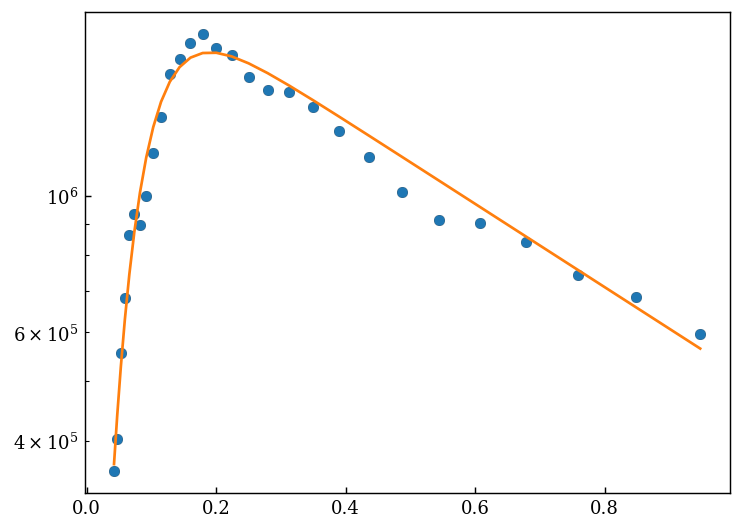

In [113]:
plt.semilogy(bins_center*1e6, pdf, 'o')
plt.plot(bins_center*1e6, Peq(bins_center, *popt), ls='-')